In [37]:
import math
import torch
import numpy as np

class RBFSolver():
    def __init__(self):
         self.predict_x0 = True
         pass

    def get_kernel_matrix(self, lambdas, beta):
            # (p, 1)
            lambdas = lambdas[:, None]
            # (p, p)
            K = torch.exp(-beta**2 * (lambdas - lambdas.T) ** 2)
            return K

    def get_integral_vector(self, lambda_s, lambda_t, lambdas, beta):
        
        # Handle the zero-beta case.
        if beta == 0:
            if self.predict_x0:
                return (torch.exp(lambda_t) - torch.exp(lambda_s)) * torch.ones_like(lambdas)
            else:    
                return (torch.exp(-lambda_s) - torch.exp(-lambda_t)) * torch.ones_like(lambdas)
            
        h = lambda_t - lambda_s
        s = 1/(beta*h)
        log_s = torch.log(s)

        # closed-form
        if log_s < 0:
            def log_erf_diff(a, b):
                return torch.log(torch.erfc(b)) + torch.log(1.0-torch.exp(torch.log(torch.erfc(a)) - torch.log(torch.erfc(b))))
    
            r_u = (lambdas - lambda_s) / h
            log_prefactor = lambda_t + torch.log(h) + ((s*h)**2/4 + h*(r_u-1)) + torch.log(0.5*np.sqrt(np.pi)*s)
            upper = (r_u + s**2*h/2)/s
            lower = (r_u + s**2*h/2 - 1)/s
            result = torch.exp(log_prefactor + log_erf_diff(upper, lower))
            return result.float()

        # Gaussian-Legendre Quadrature 10-points
        # Coefficients from from sympy.integrals.quadrature import gauss_legendre
        else:    
            x = torch.tensor([
                -0.973906528517172,
                -0.865063366688985,
                -0.679409568299024,
                -0.433395394129247,
                -0.148874338981631,
                0.148874338981631,
                0.433395394129247,
                0.679409568299024,
                0.865063366688985,
                0.973906528517172,
                ], device=lambdas.device).to(torch.float64)
            w = torch.tensor([
                0.0666713443086881,
                0.149451349150581,
                0.219086362515982,
                0.269266719309996,
                0.295524224714753,
                0.295524224714753,
                0.269266719309996,
                0.219086362515982,
                0.149451349150581,
                0.0666713443086881,
                ], device=lambdas.device).to(torch.float64)
            
            def f1(lam):
                return torch.exp(lam - beta**2*(lam-lambdas[None, :])**2)
            def f2(lam):
                return (lambda_t-lambda_s)/2 * f1(lam*(lambda_t-lambda_s)/2 + (lambda_s+lambda_t)/2)
            
            # (1, p) = (1, n) @ (n, p)
            result = (w[None, :] @ f2(x[:, None]))[0]
            
            return result.float()

    def get_coefficients(self, lambda_s, lambda_t, lambdas, beta):
        lambda_s = lambda_s.to(torch.float64)
        lambda_t = lambda_t.to(torch.float64)
        lambdas = lambdas.to(torch.float64)
        beta = beta.to(torch.float64)

        p = len(lambdas)
        # (p,)
        integral1 = self.get_integral_vector(lambda_s, lambda_t, lambdas, beta)
        #print('integral1 :', lambda_s, beta, integral1)
        # (1,)
        integral2 = self.get_integral_vector(lambda_s, lambda_t, lambdas[:1], beta=0)
        
        # (p+1,)
        integral_aug = torch.cat([integral1, integral2], dim=0)
        print(integral_aug)

        # (p, p)
        kernel = self.get_kernel_matrix(lambdas, beta)
        eye = torch.eye(p+1, device=kernel.device).to(torch.float64)
        kernel_aug = 1 - eye
        kernel_aug[:p, :p] = kernel
        # (p,)
        #coefficients = (integral_aug[None, :] @ torch.linalg.pinv(kernel_aug))[0, :p]    
        #coefficients = (integral_aug[None, :] @ torch.linalg.inv(kernel_aug))[0, :p]
        coefficients = torch.linalg.solve(kernel_aug, integral_aug)
        #coefficients = torch.linalg.lstsq(kernel_aug, integral_aug).solution
        #coefficients = self.solve_linear_system(kernel_aug, integral_aug)
        #error = torch.mean(abs(integral_aug - kernel_aug @ coefficients)).item()
        coefficients = coefficients[:p]  # (p+1,) 중 앞 p개만 슬라이싱
        return coefficients.float()

    def get_lag_kernel_matrix(self, lambdas):
        return torch.vander(lambdas, N=len(lambdas), increasing=True)

    def get_lag_integral(self, a: float, b: float, k: int) -> float:
        if k < 0 or not float(k).is_integer():
            raise ValueError("k must be a non-negative integer.")

        k = int(k)  # 확실하게 int 변환
        k_factorial = math.factorial(k)

        def F(x: float) -> float:
            # F(λ) = -k! * exp(-λ) * Σ_{m=0}^k [λ^m / m!]
            poly_sum = 0.0
            for m in range(k+1):
                poly_sum += (x**m) / math.factorial(m)

            return -k_factorial * math.exp(-x) * poly_sum
        
        def G(x: float) -> float:
            # G(λ) = (-1)^k * k! * exp(λ) * Σ_{m=0}^k [(-λ)^m / m!]
            poly_sum = 0.0
            for m in range(k+1):
                poly_sum += ((-x)**m) / math.factorial(m)

            return (-1)**k * k_factorial * math.exp(x) * poly_sum

        if self.predict_x0:
            return G(b) - G(a)
        else:
            return F(b) - F(a)

    def get_lag_integral_vector(self, lambda_s, lambda_t, lambdas):
        vector = [self.get_lag_integral(lambda_s, lambda_t, k) for k in range(len(lambdas))]
        return torch.tensor(vector, device=lambdas.device)

    def get_lag_coefficients(self, lambda_s, lambda_t, lambdas):
        # (p,)
        integral = self.get_lag_integral_vector(lambda_s, lambda_t, lambdas)
        # (p, p)
        kernel = self.get_lag_kernel_matrix(lambdas)
        kernel_inv = torch.linalg.inv(kernel)
        # (p,)
        coefficients = kernel_inv.T @ integral
        return coefficients
    
    

In [38]:
solver = RBFSolver()
lambda_s = torch.tensor(0.0)
lambda_t = torch.tensor(0.1)
lambdas = torch.tensor([-0.2, -0.1, 0.0])
log_scales = torch.linspace(-3, 3, 100)
rbf_coefficients = []
for log_scale in log_scales:
    beta = 1 / (torch.exp(log_scale) * abs(lambda_t - lambda_s))
    coefficients = solver.get_coefficients(lambda_s, lambda_t, lambdas, beta)
    rbf_coefficients.append(coefficients)
rbf_coefficients = torch.stack(rbf_coefficients)
print(rbf_coefficients.shape)
lag_coefficient = solver.get_lag_coefficients(lambda_s, lambda_t, lambdas)
print(lag_coefficient.shape)


tensor([0.0000, 0.0000, 0.0044, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0047, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0050, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0053, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0056, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0060, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0064, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0068, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0072, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0076, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0081, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0086, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0092, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0098, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0104, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0110, 0.1052], dtype=torch.float64)
tensor([

tensor([0.0000, 0.0000, 0.0044, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0000, 0.0086, 0.1052], dtype=torch.float64)
tensor([0.0000e+00, 1.1772e-15, 1.6919e-02, 1.0517e-01], dtype=torch.float64)
tensor([4.8617e-16, 3.9667e-06, 3.3286e-02, 1.0517e-01], dtype=torch.float64)
tensor([5.0755e-06, 3.1285e-03, 6.2688e-02, 1.0517e-01], dtype=torch.float64)
tensor([0.0051, 0.0345, 0.0893, 0.1052], dtype=torch.float64)
tensor([0.0452, 0.0770, 0.1005, 0.1052], dtype=torch.float64)
tensor([0.0839, 0.0967, 0.1039, 0.1052], dtype=torch.float64)
tensor([0.0991, 0.1029, 0.1048, 0.1052], dtype=torch.float64)
tensor([0.1035, 0.1046, 0.1051, 0.1052], dtype=torch.float64)


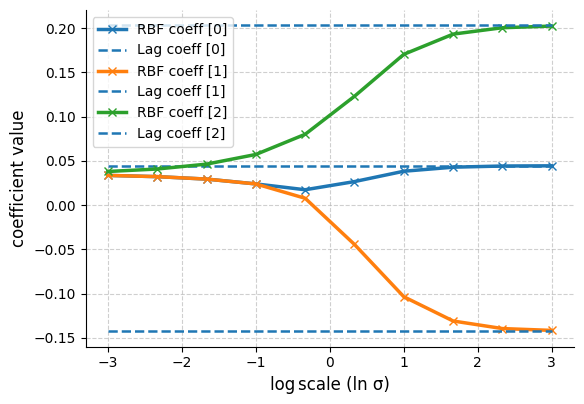

In [39]:
import torch
import matplotlib.pyplot as plt

# ── 1. coefficient 계산 ────────────────────────────────────────────────
solver = RBFSolver()                             # 이미 정의돼 있다고 가정
λ_s, λ_t = torch.tensor(0.0), torch.tensor(0.1)
lambdas   = torch.tensor([-0.2, -0.1, 0.0])

log_scales = torch.linspace(-3, 3, 10)          # (← scale ↑  ⇒  basis ↑ flat)
rbf_coeffs = []
for log_scale in log_scales:
    β = 1.0 / (torch.exp(log_scale) * abs(λ_t - λ_s))
    rbf_coeffs.append(
        solver.get_coefficients(λ_s, λ_t, lambdas, β)      # shape = (3,)
    )
rbf_coeffs = torch.stack(rbf_coeffs)             # shape = (100, 3)

lag_coeff = solver.get_lag_coefficients(λ_s, λ_t, lambdas)  # shape = (3,)

# ── 2. global 스타일 ──────────────────────────────────────────────────
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.6,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ── 3. plot ───────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 4.2))

for i in range(3):
    # RBF coefficient (solid, marker “x”)
    ax.plot(
        log_scales.numpy(),
        rbf_coeffs[:, i].numpy(),
        label=f"RBF coeff [{i}]",
        linewidth=2.5,
        marker="x",
    )
    # Lagrange coefficient (horizontal dashed)
    ax.hlines(
        lag_coeff[i].item(),
        log_scales.min().item(),
        log_scales.max().item(),
        linestyle="--",
        linewidth=1.8,
        label=f"Lag coeff [{i}]",
    )

ax.set_xlabel("log scale (ln σ)")
ax.set_ylabel("coefficient value")
ax.legend(loc="best")
fig.tight_layout()
plt.show()


tensor([0.0000, 0.0044, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0047, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0050, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0053, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0056, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0060, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0064, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0068, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0072, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0076, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0081, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0086, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0092, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0098, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0104, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0110, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0117, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0125, 0.1052], dtype=torch.float64)
tensor([0.0000, 0.0132, 0.10

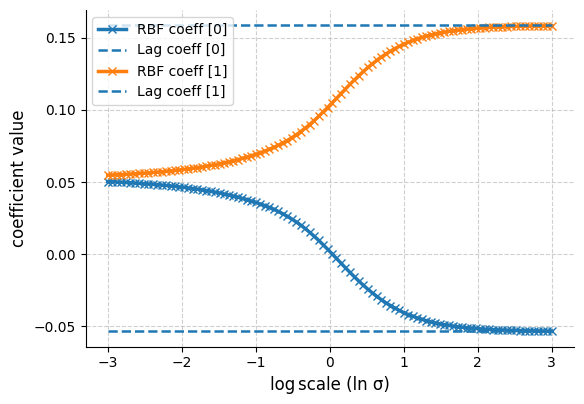

In [40]:
import torch
import matplotlib.pyplot as plt

# ── 1. coefficient 계산 ────────────────────────────────────────────────
solver = RBFSolver()                             # 이미 정의돼 있다고 가정
λ_s, λ_t = torch.tensor(0.0), torch.tensor(0.1)
lambdas   = torch.tensor([-0.1, 0.0])            # ← 변경된 λ 리스트 (2개)

log_scales = torch.linspace(-3, 3, 100)
rbf_coeffs = []
for log_scale in log_scales:
    β = 1.0 / (torch.exp(log_scale) * abs(λ_t - λ_s))
    rbf_coeffs.append(
        solver.get_coefficients(λ_s, λ_t, lambdas, β)      # shape = (2,)
    )
rbf_coeffs = torch.stack(rbf_coeffs)             # shape = (100, 2)

lag_coeff = solver.get_lag_coefficients(λ_s, λ_t, lambdas)  # shape = (2,)

# ── 2. global 스타일 ──────────────────────────────────────────────────
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.6,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ── 3. plot ───────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 4.2))

for i in range(len(lambdas)):
    # RBF coefficient (solid, marker “x”)
    ax.plot(
        log_scales.numpy(),
        rbf_coeffs[:, i].numpy(),
        label=f"RBF coeff [{i}]",
        linewidth=2.5,
        marker="x",
    )
    # Lagrange coefficient (horizontal dashed)
    ax.hlines(
        lag_coeff[i].item(),
        log_scales.min().item(),
        log_scales.max().item(),
        linestyle="--",
        linewidth=1.8,
        label=f"Lag coeff [{i}]",
    )

ax.set_xlabel("log scale (ln σ)")
ax.set_ylabel("coefficient value")
ax.legend(loc="best")
fig.tight_layout()
plt.show()
